# Imports

In [1]:
import wandb
from wandb.integration.keras import WandbCallback
wandb.login()

2024-06-26 15:16:40.374968: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alvaro-francisco-gil (orbit-generation). Use `wandb login --relogin` to force relogin


True

In [2]:
import tensorflow as tf

# List available physical devices
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs found: {len(gpus)}")

# Print GPU details
for i, gpu in enumerate(gpus):
    print(f"GPU {i}: {gpu}")

# Assuming 'GPU:1' is the identifier for the second GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Disable first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("Logical GPUs:", logical_gpus)
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)



GPUs found: 3
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU 1: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
GPU 2: PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')
Logical GPUs: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2024-06-26 15:16:43.881280: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 15:16:44.554439: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21790 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:18:00.0, compute capability: 8.6


In [3]:
from orbit_generation.constants import EM_MU
from orbit_generation.processing import reorder_orbits
from orbit_generation.visualize import export_dynamic_orbits_html, visualize_static_orbits, plot_latent_space_2d
from orbit_generation.stats import plot_histograms_comparison, reduce_dimensions_plot_combined_latent_space, reduce_dimensions_plot_latent_space
from orbit_generation.dataset import get_first_period_dataset, get_orbit_classes
from orbit_generation.model import get_optimizer, get_model, extract_plot_and_return_metrics
from orbit_generation.propagation import calculate_errors
from orbit_generation.experiment import setup_new_experiment, convert_notebook, add_experiment_metrics

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-26 15:16:52.784760: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-06-26 15:16:52.787166: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x6fb1390


In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tsgm
import os

# Parameters

In [5]:
want_to_train = False        # Set this parameter to False if you want to load the model from the folder
want_to_generate = True     # Set this parameter to False if you want to load the generation from the folder
calculate_metrics = True    # Set this parameter to False if you don't want to calculate any metric

In [6]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = "../experiments"

In [7]:
params = {
    'model_name': 'vae_conv5',
    'data_used': os.path.splitext(os.path.basename(data_path))[0],
    'latent_dim': 2,
    'feature_dim': 7,
    'seq_len': 300,
    'val_split': 0.2,
    'batch_size': 32,
    'epochs': 25,
    'optimizer': {
        'name': 'Adam',
        'learning_rate': 0.001
    },
    'num_samples': 100
}

In [8]:
if want_to_train:
    # Initialize a new run
    wandb.init(project='orbit-generation', entity='alvaro-francisco-gil', config=params)

# Data

## Import

In [9]:
data, orbit_df, labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=params['seq_len'])
data.shape

(45211, 7, 300)

## Shuffle

In [10]:
# Set a random seed for reproducibility
np.random.seed(42) 

# Create an array of indices based on the length of the data
indices = np.arange(data.shape[0])

# Shuffle the indices
np.random.shuffle(indices)

# Use the shuffled indices to reorder the data and labels
data = data[indices]
labels = np.array(labels)
labels = labels[indices]

## Transpose

In [11]:
transposed_orbits = np.transpose(data, (0, 2, 1))

## Scaling

In [12]:
scaler = tsgm.utils.TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(transposed_orbits)
del transposed_orbits
scaled_data.shape

(45211, 300, 7)

# Modelling

In [13]:
if want_to_train:
    model = get_model(params)
    optimizer = get_optimizer(params['optimizer'])
    
    metrics = {}

    # Compile the model with the configured optimizer from the params dictionary
    model.compile(optimizer=optimizer)

    # Fit the model using the scaled data and parameters from the dictionary
    history = model.fit(
        scaled_data, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_split=params['val_split'],  # Adjust the split ratio as needed
        callbacks=[WandbCallback()]
    )

    # Extract, plot, and return metrics
    training_metrics = extract_plot_and_return_metrics(history, validation=False)

## Saving

In [14]:
experiment_folder = setup_new_experiment(params, experiments_folder)
experiment_id = os.path.basename(experiment_folder).split('_')[1]

Parameters already exist for experiment: ../experiments/experiment_1


In [15]:
if want_to_train:
    add_experiment_metrics(experiments_folder, params=params, metrics=training_metrics)

In [16]:
# Define full paths for saving

generated_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_data.npy')
static_all_orbit_path = os.path.join(experiment_folder, f'exp{experiment_id}_all_generated_data.png')
static_some_orbit_path = os.path.join(experiment_folder, f'exp{experiment_id}_some_generated_data.png')
dynamic_orbits_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_orbits.html')
latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_representations.npy')
sampled_latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_sampled_latent_representations.npy')
labels_latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_labels_latent_representations.npy')
labels_sampled_latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_labels_sampled_latent_representations.npy')
latent_space_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_space')
combined_latent_space_path = os.path.join(experiment_folder, f'exp{experiment_id}_combined_dimensionality_reduction_latent_space')

In [17]:
if want_to_train:
    if params['model_name']=='vae_conv5':
        encoder_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_encoder')
        decoder_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_decoder')
        model.encoder.save(encoder_save_path, save_format='tf')
        model.decoder.save(decoder_save_path, save_format='tf')
    else:
        model_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_model')
        model.save(model_save_path, save_format='tf')
else:
    if params['model_name']=='vae_conv5':
        encoder_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_encoder')
        decoder_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_decoder')
        encoder = tf.keras.models.load_model(encoder_save_path)
        decoder = tf.keras.models.load_model(decoder_save_path)
        model = tsgm.models.cvae.BetaVAE(encoder, decoder)
    else:
        model_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_model')
        model = tf.keras.models.load_model(model_save_path)

## Generate

In [18]:
if want_to_generate:
    # Generate the orbits
    generation = model.generate(params['num_samples'])
    generation = scaler.inverse_transform(generation)
    np.save(generated_data_path, generation)
else:
    # Load the orbits
    generation = np.load(generated_data_path)

generation.shape

2024-06-26 15:17:53.512772: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


TensorShape([100, 300, 7])

# Analysis of Generation

## Visualization

In [19]:
if generation.shape[2] == 7:
    no_time_generation = generation[:,:,1:]
    generation.shape
else:
    no_time_generation = generation

no_time_generation.shape

TensorShape([100, 300, 6])

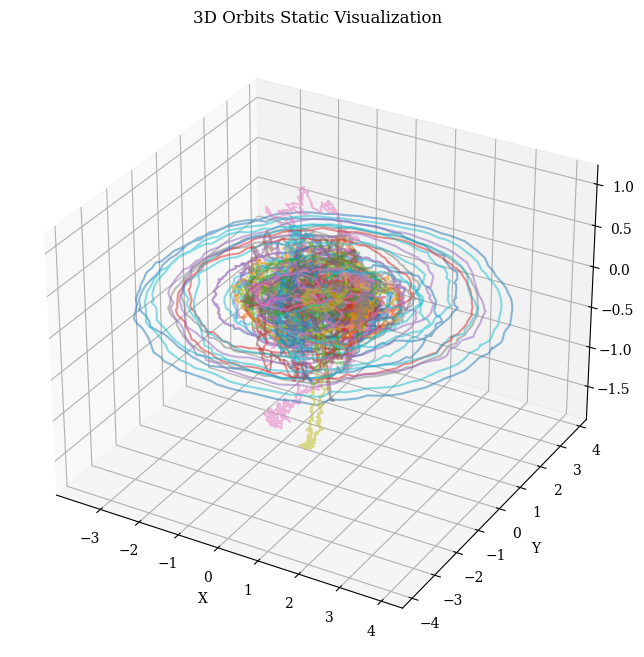

In [20]:
visualize_static_orbits(data= np.transpose(no_time_generation, (0, 2, 1)), show_legend=False, save_path=static_all_orbit_path)

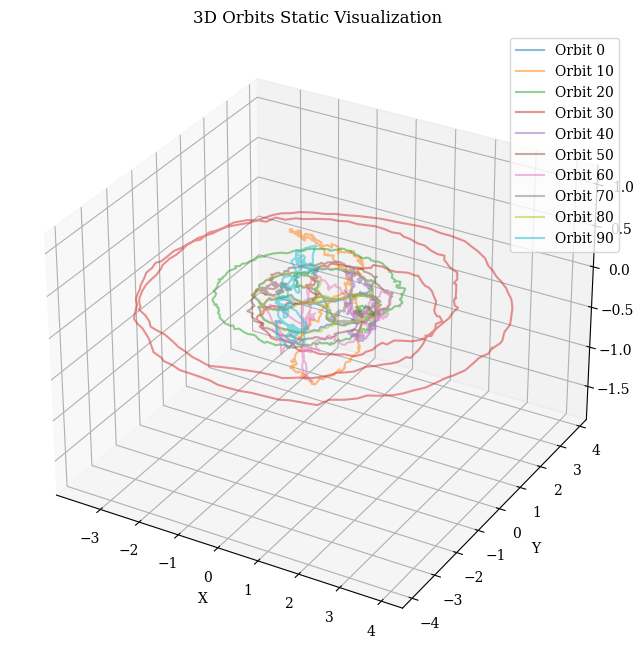

In [21]:
visualize_static_orbits(data= np.transpose(no_time_generation, (0, 2, 1)), orbit_indices=[0,10,20,30,40,50,60,70,80,90], save_path=static_some_orbit_path)

In [22]:
export_dynamic_orbits_html(data=np.transpose(no_time_generation, (0, 2, 1)), filename=dynamic_orbits_path)

Visualization saved to ../experiments/experiment_1/exp1_generated_orbits.html


## Coverage

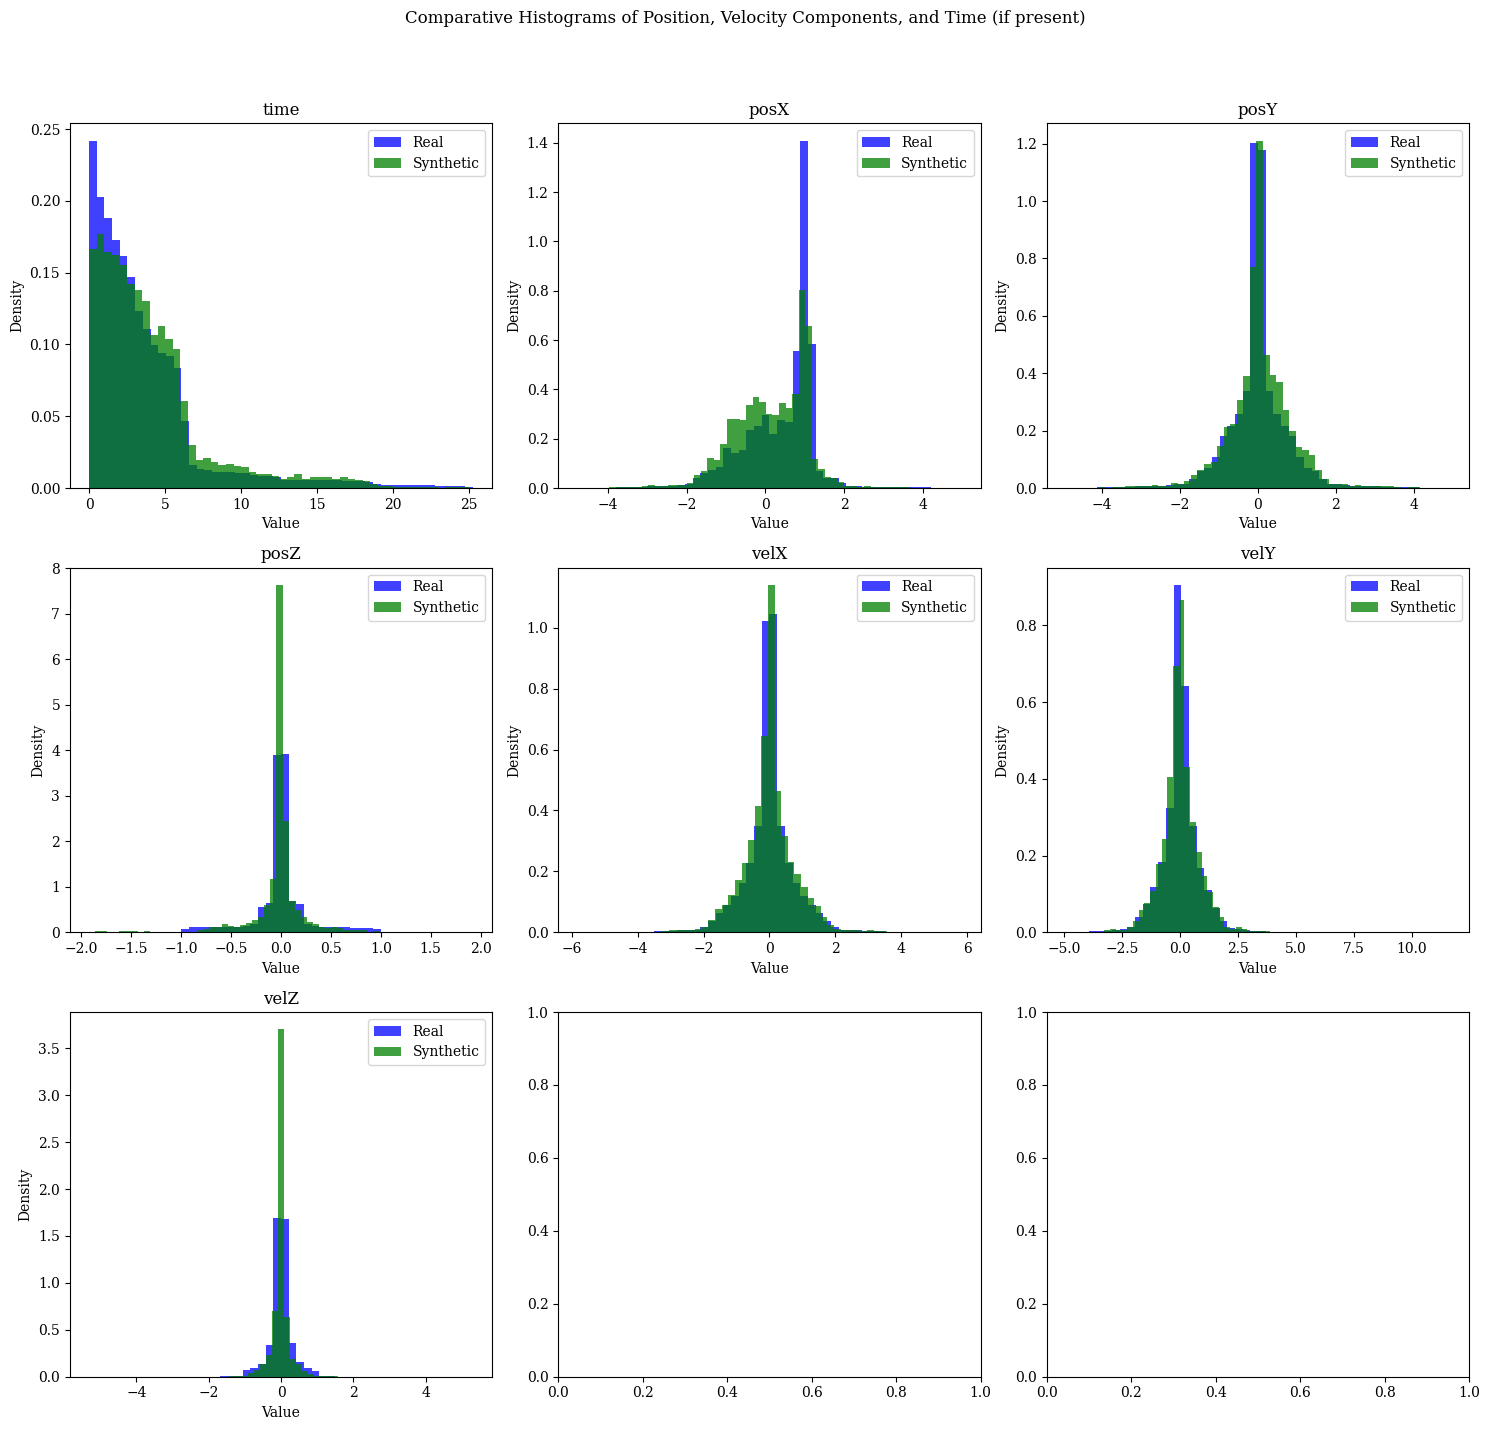

In [23]:
plot_histograms_comparison(data1=data, data2=np.transpose(generation, (0, 2, 1)), label1='Real', label2='Synthetic', normalize=True)

## Pheasibility

Cumulative position error for selected orbits: 5953.628132235644
Average position error per time step: 19.91179977336336


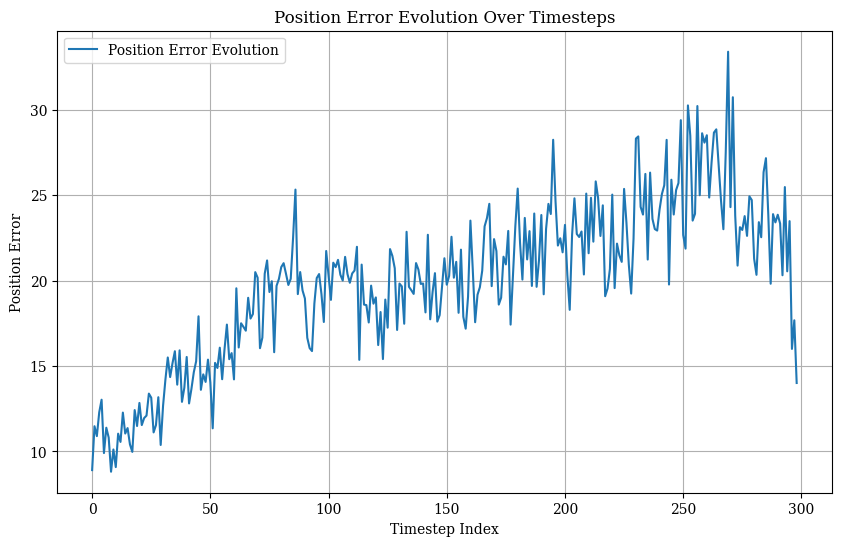

Cumulative velocity error for selected orbits: 9421.233245967238
Average velocity error per time step: 31.509141290860327


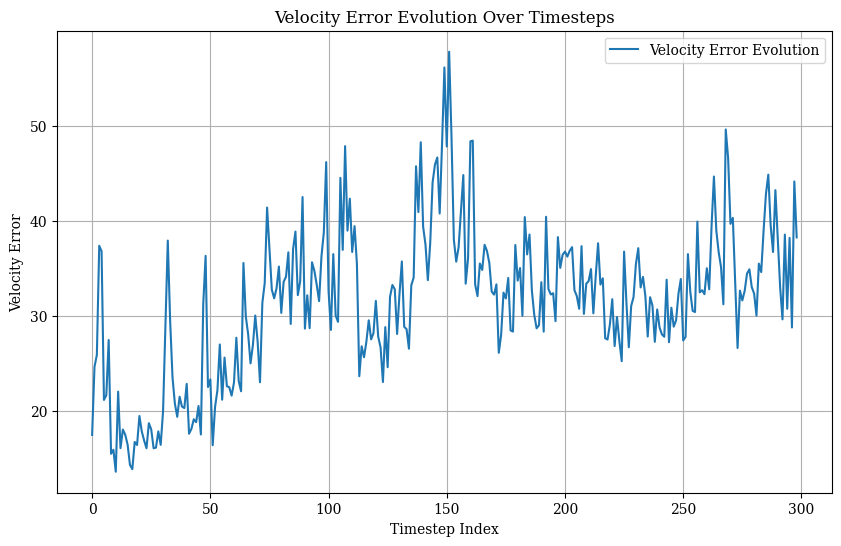

Cumulative energy error for selected orbits: 19932.946887402115
Average energy error per time step: 66.66537420535825


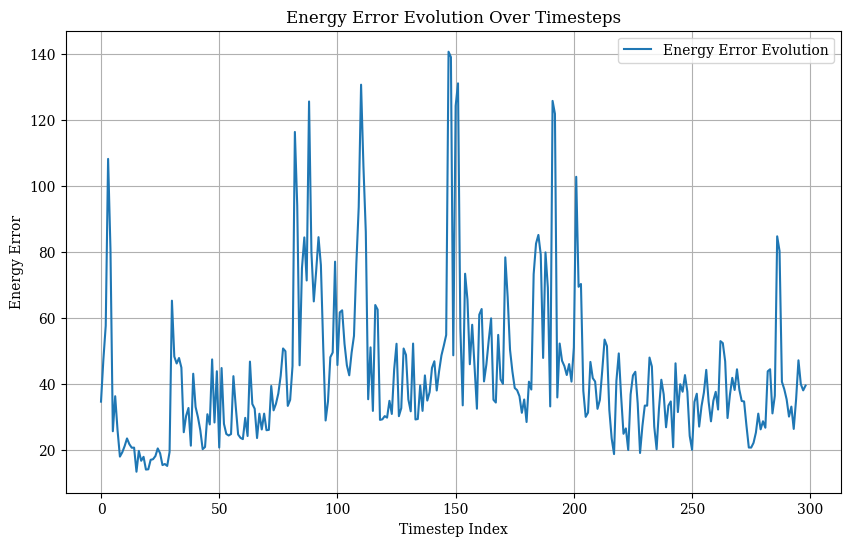

Metrics added to experiment with ID 1 in ../experiments/experiments.json.


In [24]:
if calculate_metrics:
    # add model metrics
    reordered_orbits, order_metrics = reorder_orbits(np.transpose(generation, (0, 2, 1)))
    errors = calculate_errors(reordered_orbits,EM_MU,time_step=0.01)

    # Add metrics
    add_experiment_metrics(experiments_folder, params=params, metrics={**errors, **order_metrics})

# Latent Visualization

## Sampling

In [25]:
np.random.seed(42)

# Randomly choose indices
random_indices = np.random.choice(data.shape[0], size=5000, replace=False)

# Select the samples
sampled_data = scaled_data[random_indices]
sampled_labels = labels[random_indices]

sampled_data.shape

(5000, 300, 7)

In [26]:
latent_mean, latent_deviation, latent_epsilon = model.encoder(sampled_data)
sampled_latent_representations = latent_mean.numpy()

np.save(sampled_latent_representations_path, sampled_latent_representations)
np.save(labels_sampled_latent_representations_path, sampled_labels)

sampled_latent_representations.shape

(5000, 2)

In [27]:
sampled_id_classes = [orbit_df.at[index, 'id_class'] for index in sampled_labels]
sampled_classes=get_orbit_classes(sampled_id_classes)

## Orbit Classifications

Saved plot to ../experiments/experiment_1/exp1_latent_space_label


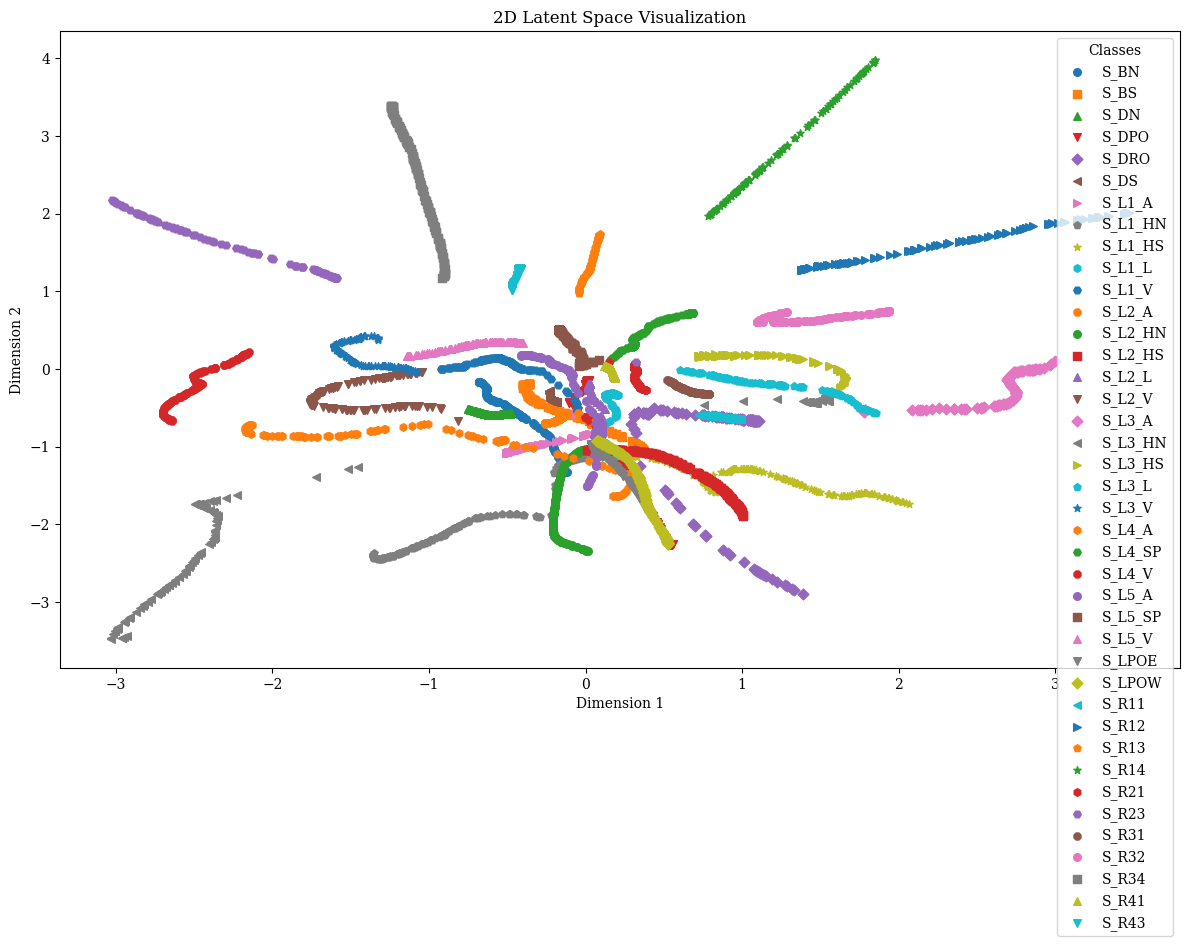

Saved plot to ../experiments/experiment_1/exp1_latent_space_type


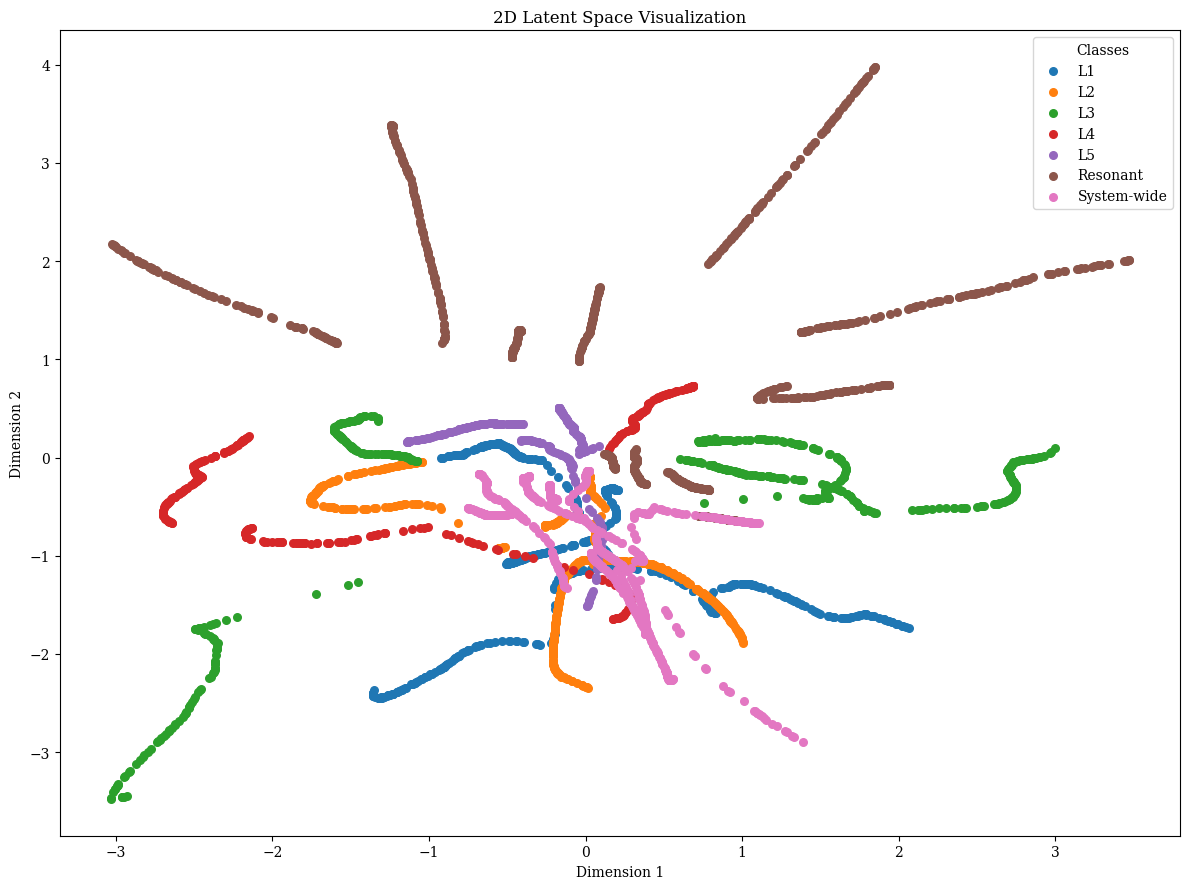

Saved plot to ../experiments/experiment_1/exp1_latent_space_subtype


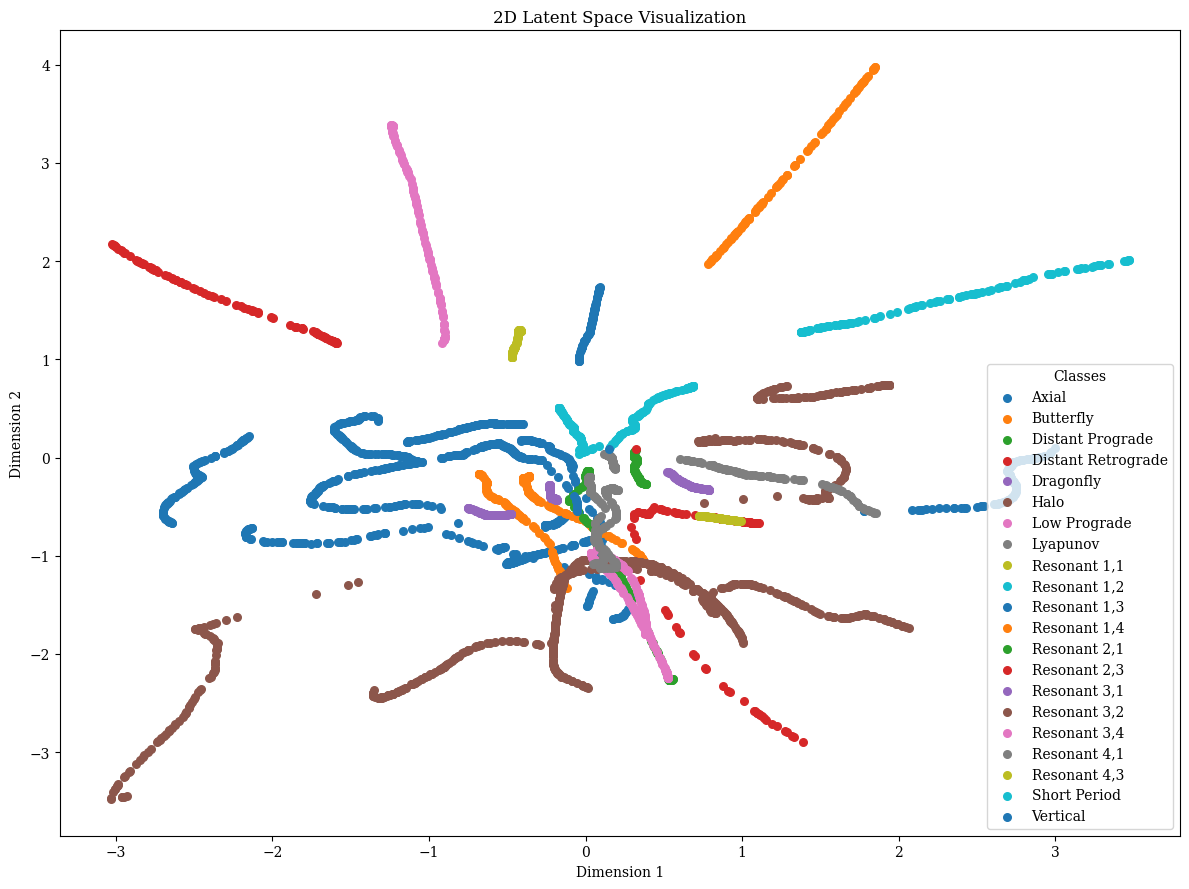

Saved plot to ../experiments/experiment_1/exp1_latent_space_direction


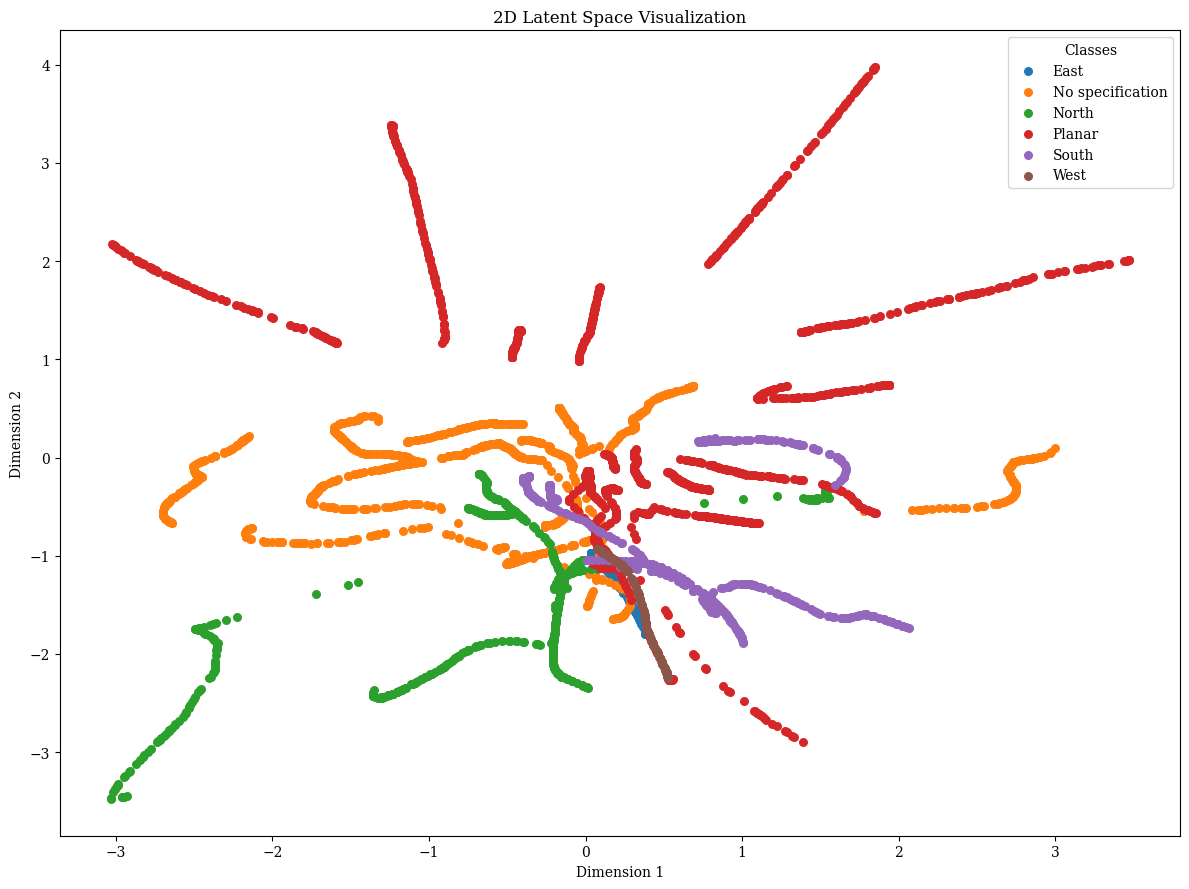

In [28]:
if sampled_latent_representations.shape[1]==2:
    plot_latent_space_2d(sampled_latent_representations, np.array(sampled_classes[0]), save_path=latent_space_path +'_label', many_classes=True)
    plot_latent_space_2d(sampled_latent_representations, np.array(sampled_classes[1]), save_path=latent_space_path +'_type')
    plot_latent_space_2d(sampled_latent_representations, np.array(sampled_classes[2]), save_path=latent_space_path +'_subtype')
    plot_latent_space_2d(sampled_latent_representations, np.array(sampled_classes[3]), save_path=latent_space_path +'_direction')
else:
    reduce_dimensions_plot_latent_space(sampled_latent_representations, np.array(sampled_classes[0]), techniques=['PCA','t-SNE','UMAP', 'LDA'], save_path=latent_space_path +'_label', many_classes=True, grid_view=False)
    reduce_dimensions_plot_latent_space(sampled_latent_representations, np.array(sampled_classes[1]), techniques=['PCA','t-SNE','UMAP', 'LDA'], save_path=latent_space_path +'_type')
    reduce_dimensions_plot_latent_space(sampled_latent_representations, np.array(sampled_classes[2]), techniques=['PCA','t-SNE','UMAP', 'LDA'], save_path=latent_space_path +'_subtype')
    reduce_dimensions_plot_latent_space(sampled_latent_representations, np.array(sampled_classes[3]), techniques=['PCA','t-SNE','UMAP', 'LDA'], save_path=latent_space_path +'_direction')

In [29]:
wandb.finish()